In [1]:
# Local clone
! git clone https://github.com/nanopiero/CML_processing_by_ML.git

Cloning into 'CML_processing_by_ML'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 325 (delta 76), reused 10 (delta 10), pack-reused 207 (from 1)
Receiving objects: 100% (325/325), 11.16 MiB | 18.05 MiB/s, done.
Resolving deltas: 100% (186/186), done.


In [2]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np

import sys
sys.path.append('CML_processing_by_ML')

from src.utils.simulation import create_dataloader
import src.utils.architectures_fcn
from src.utils.architectures import load_archi
from src.utils.architectures_fcn import UNet_causal_5mn_atrous, UNet_causal_5mn_atrous_rescale

In [3]:
# Dictionary with pseudo "distances" (distances between two antennnas) for 1,000 pseudo CML ids.
idx2distance = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
duration = 4096  # length of the time series
batch_size = 100  # Number of samples per batch
dataloader = create_dataloader(duration, idx2distance, batch_size)

In [4]:
# Here we samples 100 ground-truth rainy processes and their noisy counterpart
# A rainy process is modeled by a 1-d Neymann-Scott process
# The Intensity of the Poisson process for parent events is 0.05 x distance
# The resulting rainy process is divided by the distance to give the "ground truth"
# while it is corrupted through the following steps to yield "noisy_series":
# - applying a non linear conversion to an attenuation in db
# - applying a "wet antenna convolution filter" (kind of sliding mean)
# - adding a high (gaussian noise with non linear dependance of sigma wrt the intensity)
# - adding a low frequency random processes

for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
  if batch_idx == 0:
    break

In [ ]:
import matplotlib.pyplot as plt
sigma = 2
for k in range(5):
  print(idxs[k], dists[k])
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), ground_truths[k], label='ground_truth')
  plt.plot(np.arange(duration), noisy_series[k], label='predictor')
  plt.title(f'Inputs and Targets for the CML n°{idxs[k].item():.0f} (ditance: {dists[k].item():.2f})')
  plt.xlabel('Time (minutes)')
  plt.ylabel('Event Density')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

In [ ]:
# Same weights for all CMLs

arch = "UNet_causal_5mn_atrous"
nchannels = 1
nclasses = 1 # Regression only
dilation = 2
atrous_rates=[6, 12, 18] #, 24, 30, 36, 42]
additional_parameters = 0

model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

num_epochs = 300  # Adjust based on your needs

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, targets = noisy_series.to(device), \
                          ground_truths.to(device)

        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, num_samples=1):
    model.eval()
    L = 1000
    with torch.no_grad():
        for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):

            inputs = noisy_series.to(device).unsqueeze(1).float()  # Adjust input dimensions
            outputs = model(inputs).cpu()

            for i in range(num_samples):
                plt.figure(figsize=(16, 4))
                # plt.plot(noisy_series[i].squeeze(), label='input')
                plt.plot(ground_truths[i,:L].squeeze(), label='Observation')
                plt.plot(outputs[i].squeeze()[:L], label='Prediction', linestyle='--')
                plt.legend()
                plt.show()
            break  # Just show the first batch

visualize_predictions(model, dataloader, num_samples=5)


In [ ]:
# How to do better ?

In [ ]:
# sol 1 : UNet_causal_5mn_atrous_rescale: adds a scaling parameter for each CML

arch = "UNet_causal_5mn_atrous_rescale"
nchannels = 1
nclasses = 1 # Regression only
dilation = 2
atrous_rates=[6, 12, 18] #, 24, 30, 36, 42]
additional_parameters = 1005

model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

num_epochs = 50  # Adjust based on your needs

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, targets = noisy_series.to(device), \
                          ground_truths.to(device)

        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        outputs, p = model(inputs, indices=idxs.to(device))
        outputs[:,:,:] *= p[5:].view(outputs.shape[0],1,1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

In [44]:
# sol 2 (step 1): with UNet_causal_5mn_multiplicative_rescale,
# the scaling parameter
# is yielded by specific perceptrons (one per CML)

arch = "UNet_causal_5mn_atrous_multiplicative_rescale"
nchannels = 1
nclasses = 1
dilation = 2
atrous_rates=[6, 12, 18] #, 24, 30, 36, 42]
additional_parameters = 0

model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
# model.freeze_specific_parts()

criterion = torch.nn.MSELoss()

num_epochs = 50  # Adjust based on your needs

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, targets = noisy_series.to(device), \
                          ground_truths.to(device)

        use_first_network = torch.rand(idxs.shape, device=inputs.device) > 0.75
        idxs[use_first_network] = -1
        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, idxs.to(device))

        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch [1/50], Loss: 0.4691
Epoch [2/50], Loss: 0.2925
Epoch [3/50], Loss: 0.2658
Epoch [4/50], Loss: 0.2584
Epoch [5/50], Loss: 0.2501
Epoch [6/50], Loss: 0.2469
Epoch [7/50], Loss: 0.2453
Epoch [8/50], Loss: 0.2398
Epoch [9/50], Loss: 0.2292
Epoch [10/50], Loss: 0.2239
Epoch [11/50], Loss: 0.2164
Epoch [12/50], Loss: 0.2123
Epoch [13/50], Loss: 0.2104
Epoch [14/50], Loss: 0.2105
Epoch [15/50], Loss: 0.2027
Epoch [16/50], Loss: 0.1889
Epoch [17/50], Loss: 0.1720
Epoch [18/50], Loss: 0.1645
Epoch [19/50], Loss: 0.1664
Epoch [20/50], Loss: 0.1620
Epoch [21/50], Loss: 0.1566
Epoch [22/50], Loss: 0.1540
Epoch [23/50], Loss: 0.1541
Epoch [24/50], Loss: 0.1507
Epoch [25/50], Loss: 0.1479
Epoch [26/50], Loss: 0.1470
Epoch [27/50], Loss: 0.1454
Epoch [28/50], Loss: 0.1445
Epoch [29/50], Loss: 0.1461
Epoch [30/50], Loss: 0.1437
Epoch [31/50], Loss: 0.1431
Epoch [32/50], Loss: 0.1445
Epoch [33/50], Loss: 0.1423
Epoch [34/50], Loss: 0.1401
Epoch [35/50], Loss: 0.1400
Epoch [36/50], Loss: 0.1386
E

In [45]:
# sol 2 (step 2): the generic part is freezed while the specific perceptrons
# are fine tuned
num_epochs = 20

model.unfreeze_specific_parts()
model.freeze_generic_parts()

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, targets = noisy_series.to(device), \
                          ground_truths.to(device)

        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs, idxs.to(device))

        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch [1/20], Loss: 0.1253
Epoch [2/20], Loss: 0.1252
Epoch [3/20], Loss: 0.1245
Epoch [4/20], Loss: 0.1247
Epoch [5/20], Loss: 0.1254
Epoch [6/20], Loss: 0.1243
Epoch [7/20], Loss: 0.1239
Epoch [8/20], Loss: 0.1238
Epoch [9/20], Loss: 0.1242
Epoch [10/20], Loss: 0.1243
Epoch [11/20], Loss: 0.1254
Epoch [12/20], Loss: 0.1240
Epoch [13/20], Loss: 0.1240
Epoch [14/20], Loss: 0.1242
Epoch [15/20], Loss: 0.1238
Epoch [16/20], Loss: 0.1243
Epoch [17/20], Loss: 0.1236
Epoch [18/20], Loss: 0.1243
Epoch [19/20], Loss: 0.1247
Epoch [20/20], Loss: 0.1238


In [ ]:
# Now, let's suppose that the target itself is noisy
# and that's the case when we want to use as a target
# the reference we wish to improve.
# Here, hence, the reference is no more the ground truth RR(t) but
# its randomly-time-shifted version, that is to say,
# RR(t + delta_t), the shift delta_t slowly varying from -2 time steps to 2 time steps

# Note that the new targets are not centered on the ground truth value
# So MSE won't give the best guess (nor MAE and other standard losses)
# However, the conditional expectancy of the target knowing the ref
# is a strictly growing function of the ground truth
# so it ends up with a problem of calibration.
# As the noisy process doesn't impair the distribution, a simple
# QQ-plot will serve as calibration curve.

In [6]:
def apply_random_shifts(inputs):
    device = inputs.device
    bs = inputs.shape[0]
    N = inputs.shape[1]
    a = torch.arange(N, device=device).unsqueeze(0)
    b = 100 + 400*torch.rand(bs, 1, device=device)
    sin1 = torch.sin( 2 * torch.pi / (b * (1 + torch.rand(bs, 1, device=device))) \
                     * a + torch.rand(bs, 1, device=device))
    sin2 = torch.sin( 2 * torch.pi / (b * (1 + 2*torch.rand(bs, 1, device=device))) \
                     * a + torch.rand(bs, 1, device=device))
    sin3 = torch.sin( 2 * torch.pi / (b * (1 + 2*torch.rand(bs, 1, device=device))) * a \
                     + torch.rand(bs, 1, device=device))
    x = sin1 + sin2 + sin3
    y = 1*(x > 0.2) + 1*(x > 0.5) + 1*(x > 0.8) + 1*(x > 1.1) + 1*(x > 1.5) \
      - 1*(x < -0.8) - 1*(x < -1.1)  - 1*(x < -1.5)  - 1*(x < -0.2)

    y[:, 0:10] = 0
    y[:, -10:] = 0
    return torch.gather(inputs, 1,  a + y)

In [ ]:
# show the shifts
import matplotlib.pyplot as plt

for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
  if batch_idx == 0:
    break

reference = apply_random_shifts(ground_truths)
print(ground_truths.shape, reference.shape)
for k in range(5):
  print(idxs[k], dists[k])
  plt.figure(figsize=(20, 6))
  plt.plot(np.arange(duration)[0:360], ground_truths[k][0:360], label='ground_truth')
  plt.plot(np.arange(duration)[0:360], reference[k][0:360], label='targets')
  plt.title(f'Ground truth and Targets for the CML n°{idxs[k].item():.0f} (ditance: {dists[k].item():.2f})')
  plt.xlabel('Time (minutes)')
  plt.ylabel('Event Density')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

In [ ]:
# training the sol 2 with reference (time shifted ground truth) as target

arch = "UNet_causal_5mn_atrous_multiplicative_rescale"
nchannels = 1
nclasses = 1
dilation = 2
atrous_rates=[6, 12, 18] #, 24, 30, 36, 42]
additional_parameters = 0

model = load_archi(arch, nchannels, nclasses, size=64, dilation=1,
                   atrous_rates=atrous_rates, fixed_cumul=False,
                   additional_parameters=additional_parameters)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
# model.freeze_specific_parts()

criterion = torch.nn.MSELoss()

num_epochs = 50  # Adjust based on your needs

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    running_loss_vs_gt = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, ground_truths = noisy_series.to(device), \
                                ground_truths.to(device)

        # Here we apply a random time shift
        targets = apply_random_shifts(ground_truths)

        use_first_network = torch.rand(idxs.shape, device=inputs.device) > 0.75
        idxs[use_first_network] = -1

        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)
        ground_truths = ground_truths.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, idxs.to(device))

        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        with torch.no_grad():
          loss_vs_gt = criterion(outputs, ground_truths)
        running_loss_vs_gt += loss_vs_gt.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss vs targets: {running_loss/len(dataloader):.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss vs ground truth: {running_loss_vs_gt/len(dataloader):.4f}')


print('step 2 - fine tuning')
num_epochs = 20

model.unfreeze_specific_parts()
model.freeze_generic_parts()

for epoch in range(num_epochs):
    running_loss = 0.0
    running_loss_vs_gt = 0.0
    for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
        inputs, ground_truths = noisy_series.to(device), \
                                ground_truths.to(device)

        # Here we apply a random time shift
        targets = apply_random_shifts(ground_truths)

        # Add the channel's dim
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)
        ground_truths = ground_truths.unsqueeze(1)

        # Zeroing gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs, idxs.to(device))

        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        with torch.no_grad():
          loss_vs_gt = criterion(outputs, ground_truths)
        running_loss_vs_gt += loss_vs_gt.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss vs targets: {running_loss/len(dataloader):.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss vs ground truth: {running_loss_vs_gt/len(dataloader):.4f}')


Epoch [1/50], Loss vs targets: 0.4712
Epoch [1/50], Loss vs ground truth: 0.4263
Epoch [2/50], Loss vs targets: 0.3532
Epoch [2/50], Loss vs ground truth: 0.2829
Epoch [3/50], Loss vs targets: 0.3404
Epoch [3/50], Loss vs ground truth: 0.2661
Epoch [4/50], Loss vs targets: 0.3289
Epoch [4/50], Loss vs ground truth: 0.2507
Epoch [5/50], Loss vs targets: 0.3279
Epoch [5/50], Loss vs ground truth: 0.2496
Epoch [6/50], Loss vs targets: 0.3283
Epoch [6/50], Loss vs ground truth: 0.2466
Epoch [7/50], Loss vs targets: 0.3243
Epoch [7/50], Loss vs ground truth: 0.2400
Epoch [8/50], Loss vs targets: 0.3160
Epoch [8/50], Loss vs ground truth: 0.2316
Epoch [9/50], Loss vs targets: 0.3122
Epoch [9/50], Loss vs ground truth: 0.2259
Epoch [10/50], Loss vs targets: 0.3113
Epoch [10/50], Loss vs ground truth: 0.2255
Epoch [11/50], Loss vs targets: 0.3127
Epoch [11/50], Loss vs ground truth: 0.2269
Epoch [12/50], Loss vs targets: 0.3091
Epoch [12/50], Loss vs ground truth: 0.2250
Epoch [13/50], Loss vs

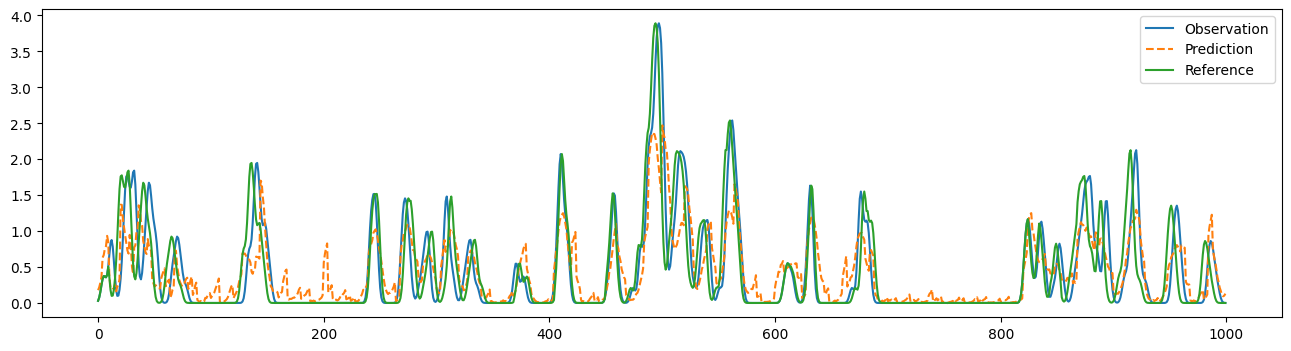

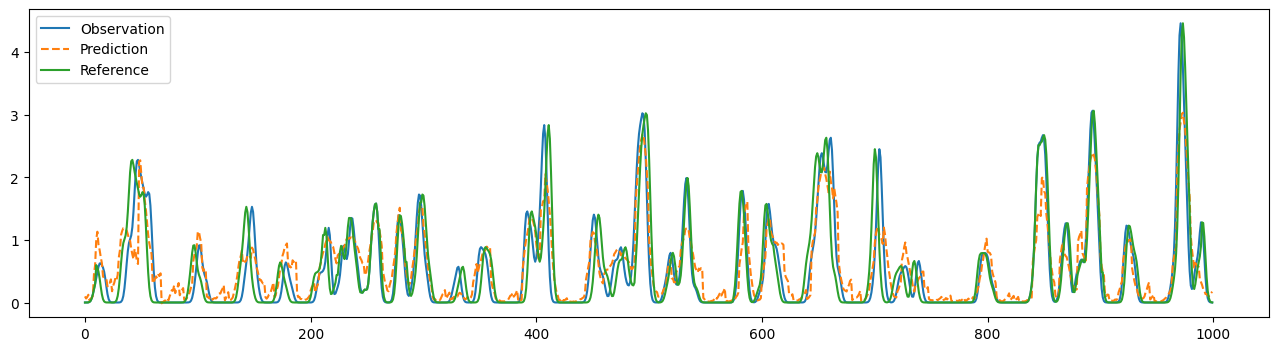

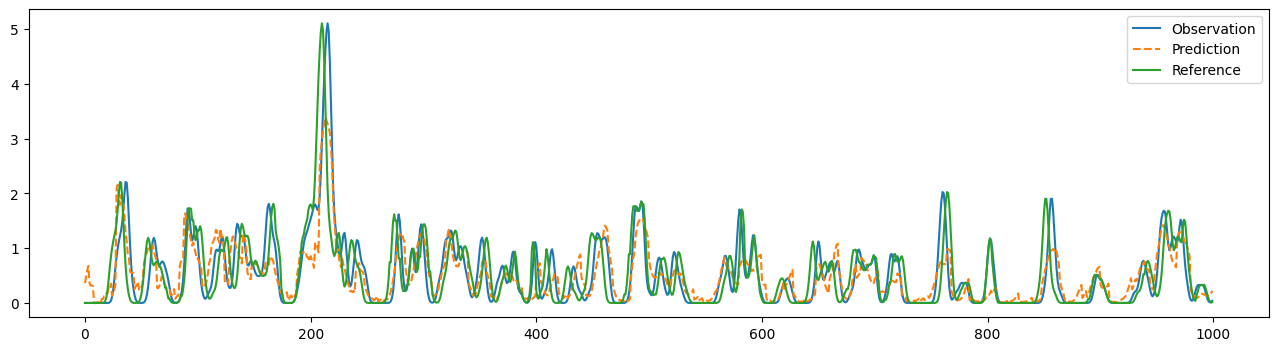

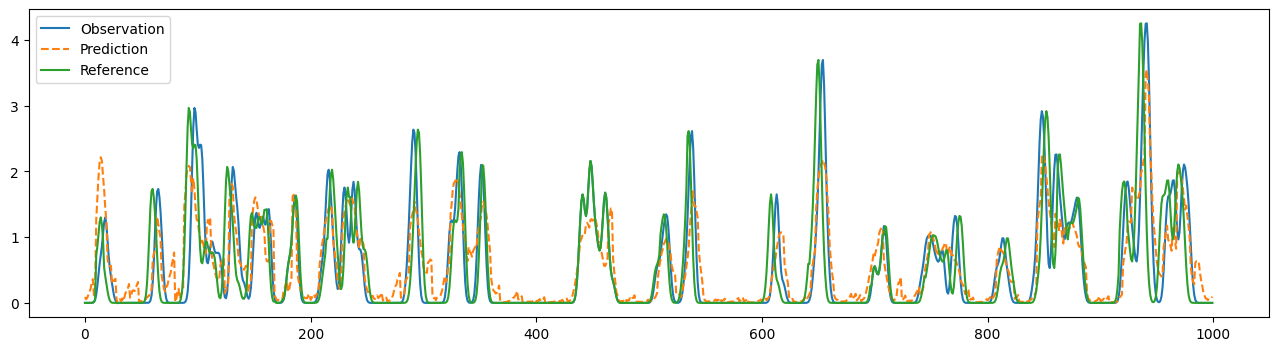

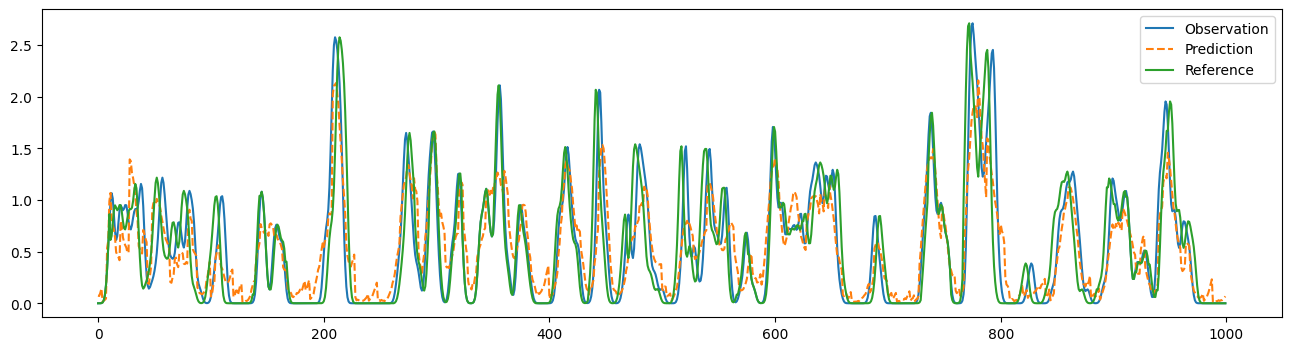

In [71]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, num_samples=1):
    model.eval()
    L = 1000
    with torch.no_grad():
        for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
            reference = apply_random_shifts(ground_truths)
            inputs = noisy_series.to(device).unsqueeze(1).float()  # Adjust input dimensions
            outputs = model(inputs, idxs.to(device)).cpu()

            for i in range(num_samples):
                plt.figure(figsize=(16, 4))
                # plt.plot(noisy_series[i].squeeze(), label='input')
                plt.plot(ground_truths[i,:L].squeeze(), label='Observation')
                plt.plot(outputs[i].squeeze()[:L], label='Prediction', linestyle='--')
                plt.plot(reference[i,:L].squeeze(), label='Reference')

                plt.legend()
                plt.show()
            break  # Just show the first batch

visualize_predictions(model, dataloader, num_samples=5)

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


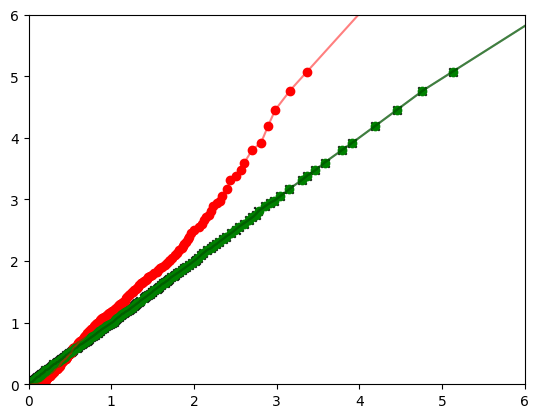

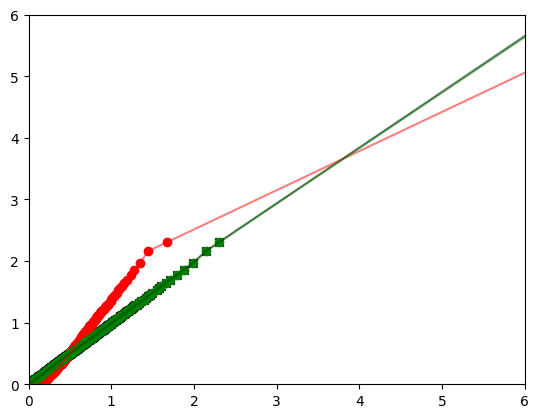

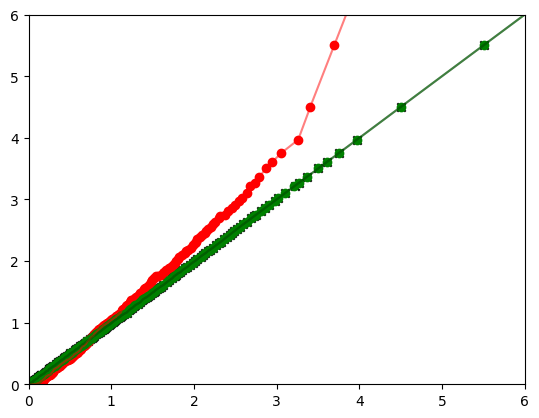

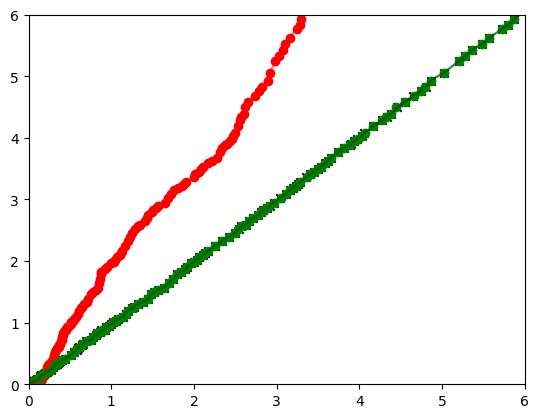

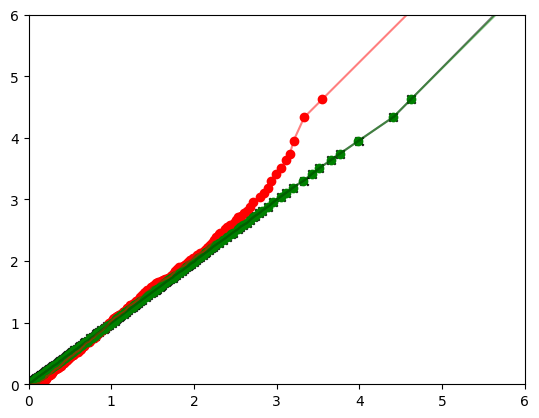

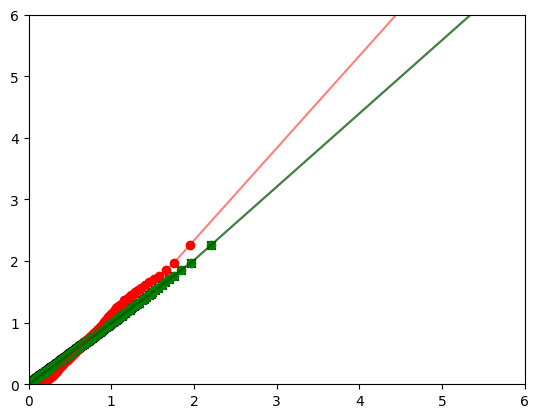

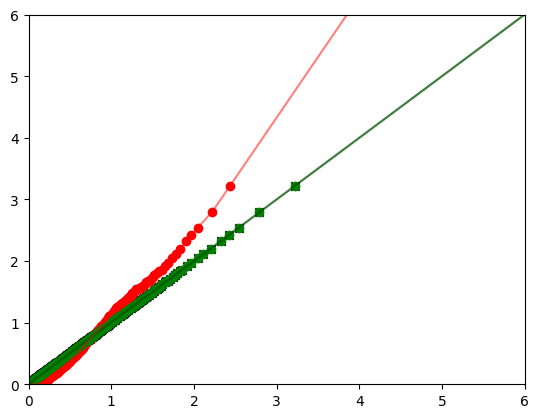

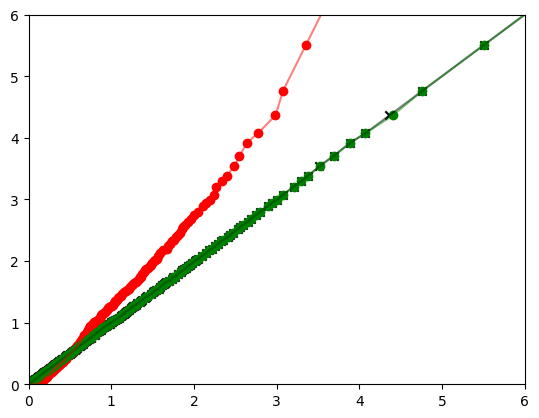

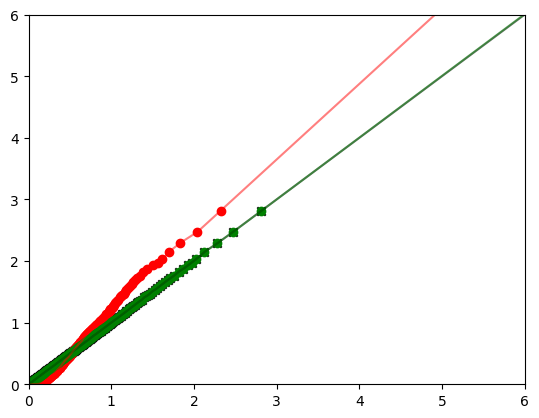

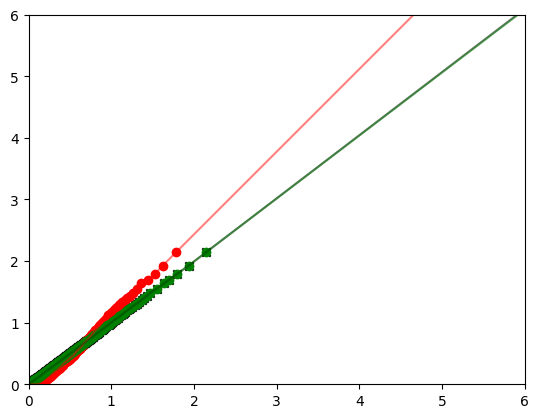

In [87]:
from scipy.interpolate import interp1d
interp = lambda x,y : interp1d(x,y,kind = 'linear', fill_value="extrapolate")

for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
  if batch_idx == 0:
    break

qstep = 0.005

reference = apply_random_shifts(ground_truths)
inputs = noisy_series.to(device).unsqueeze(1).float()  # Adjust input dimensions
outputs = model(inputs, idxs.to(device)).cpu().detach()

for k in range(10):

  plt.figure()
  outputs_k = outputs.squeeze(1)[k][reference[k]>0].numpy()
  reference_k = reference[k][reference[k]>0].numpy()
  gt_k = ground_truths[k][reference[k]>0].numpy()

  quantiles_reference = np.quantile(reference_k, np.arange(0,1,qstep))
  quantiles_outputs = np.quantile(outputs_k, np.arange(0,1,qstep))
  quantiles_gt = np.quantile(gt_k, np.arange(0,1,qstep))

  ymax=10
  ymin=0
  x = np.linspace(ymin, ymax, num = 10000)

  plt.scatter(quantiles_reference, quantiles_gt, color='black', marker='x')
  f = interp(quantiles_reference, quantiles_gt)
  plt.plot(x, f(x), alpha = 0.5, color = 'black')

  plt.scatter(quantiles_outputs, quantiles_gt, color='red')
  f = interp(quantiles_outputs, quantiles_gt)
  plt.plot(x, f(x), alpha = 0.5, color = 'red')


  f_o_ref = interp(quantiles_outputs, quantiles_reference)

  rescaled_outputs_k = f_o_ref(outputs_k)

  quantiles_rescaled_outputs_k = np.quantile(rescaled_outputs_k, np.arange(0,1,qstep))
  plt.scatter(quantiles_rescaled_outputs_k, quantiles_gt, color='green')
  f_rso_gt = interp(quantiles_rescaled_outputs_k, quantiles_gt)
  plt.plot(x, f_rso_gt(x), alpha = 0.5, color = 'green')
  plt.xlim(0,6)
  plt.ylim(0,6)



In [86]:
model.eval()

running_loss_before = 0.0
running_loss_before_vs_gt = 0.0
running_loss_after = 0.0
running_loss_after_vs_gt = 0.0

for batch_idx, (idxs, dists, ground_truths, noisy_series) in enumerate(dataloader):
  ground_truths = ground_truths.to(device)
  reference = apply_random_shifts(ground_truths)
  inputs = noisy_series.to(device)  # Adjust input dimensions


  # Add the channel's dim
  inputs = inputs.unsqueeze(1)
  reference = reference.unsqueeze(1)
  ground_truths = ground_truths.unsqueeze(1)

  outputs = model(inputs, idxs.to(device)).detach()


  with torch.no_grad():
    loss = criterion(outputs, reference)
    running_loss_before += loss.item()
    loss_vs_gt = criterion(outputs, ground_truths)
    running_loss_before_vs_gt += loss_vs_gt.item()


  for k in range(outputs.shape[0]):
    qstep = 0.005
    outputs_k = outputs[k][reference[k]>0].cpu().numpy()
    reference_k = reference[k][reference[k]>0].cpu().numpy()

    quantiles_outputs = np.quantile(outputs_k, np.arange(0,1,qstep))
    quantiles_reference = np.quantile(reference_k, np.arange(0,1,qstep))

    f_o_ref = interp(quantiles_outputs, quantiles_reference)

    rescaled_outputs_k = f_o_ref(outputs[k].cpu().numpy())

    outputs[k] = torch.tensor(rescaled_outputs_k).to(device)

  with torch.no_grad():
    loss = criterion(outputs, reference)
    running_loss_after += loss.item()
    loss_vs_gt = criterion(outputs, ground_truths)
    running_loss_after_vs_gt += loss_vs_gt.item()


print(f'Loss vs targets before calibration: {running_loss_before/len(dataloader):.4f}')
print(f'Loss vs ground truth before calibration {running_loss_before_vs_gt/len(dataloader):.4f}')

print(f'Epoch [{epoch+1}/{num_epochs}], Loss vs targets after calibration: {running_loss_after/len(dataloader):.4f}')
print(f'Epoch [{epoch+1}/{num_epochs}], Loss vs ground truth after calibration {running_loss_after_vs_gt/len(dataloader):.4f}')


Loss vs targets before calibration: 0.3198
Loss vs ground truth before calibration 0.2345
Epoch [10/50], Loss vs targets after calibration: 1.6436
Epoch [10/50], Loss vs ground truth after calibration 1.4205


In [85]:
reference.shape

torch.Size([100, 1, 4096])

In [59]:
outputs.shape[0]

100

In [10]:
from scipy.interpolate import interp1d
interp = lambda x,y : interp1d(x,y,kind = 'linear', fill_value="extrapolate")
        f = interp(qs_pred, qs_obs)
        f_inf = interp(qs_inf_pred,qs_obs)
        f_sup = interp(qs_sup_pred,qs_obs)
        ymax=qs_pred[-1]
        ymin=qs_pred[0]
        x = np.linspace(ymin-1,ymax, num = 10000)
        plt.plot(x, f(x), alpha = 0.5, color = 'green')

IndentationError: unexpected indent (<ipython-input-10-017c9fe8f739>, line 3)

In [ ]:
# calibrate the prediction

In [ ]:
# display a QQ plot of reference / prediction / calibrated prediction against ground-thruth

In [ ]:
#Display the results

In [ ]:
# To pull and reload, if needed:
! cd CML_processing_by_ML ; git pull ; cd ..

import importlib
importlib.reload(src.utils.architectures_fcn)
importlib.reload(src.utils.architectures)
from src.utils.architectures_fcn import  UNet_causal_5mn_atrous_multiplicative_rescale
from src.utils.architectures import  load_archi